In [95]:
import numpy as np
from hmmlearn import hmm
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

In [96]:
# define the hmm that generates the random states and observations
def model_gen(delta):
    """
    :param delta: float between 0.0 and 0.7 to control the flow
    :return: hmm model
    """
    components = 6
    delta = delta
    startprob = np.array([1, 0, 0, 0, 0, 0])
    transtprob = np.array([[0.1, 0.9, 0, 0, 0, 0],
                        [0.2, 0, 0.1+delta, 0, 0, 0.7-delta],
                        [0, 0.5, 0, 0.5, 0, 0],
                        [0, 0, 0.5, 0.5, 0, 0],
                        [0, 0, 0.1, 0, 0.4, 0.5],
                        [0, 0.2, 0, 0, 0.7, 0.1]])
    emissionprob = np.array([[0.25, 0.25, 0.25, 0.25],
                         [0.4, 0.3, 0.2, 0.1],
                         [0.4, 0.4, 0.1, 0.1],
                         [0.3, 0.3, 0.3, 0.1],
                         [0.2, 0.2, 0.2, 0.4],
                         [0.2, 0.2, 0.3, 0.3]
                         ])
    model = hmm.CategoricalHMM(n_components=components)
    model.transmat_ = transtprob
    model.emissionprob_ = emissionprob
    model.startprob_ = startprob
    return model

In [97]:
# get observation and latent states
def observation_sample(model_gen, k = 10):
    """
    :param model_gen: hmm model to generate from
    :param k: number of total states
    :return: [observations, latent states]
    """
    O, Q = model_gen.sample(k*2)
    observations = O[np.arange(0,2*k,2)].flatten()
    return observations, Q

In [98]:
# definition of Viterbi alg with obs every other state
def viterbi(obs, components, model):
    """
    :param obs: list of observations
    :param components: number of states
    :param model: hmm model
    :return: best states estimation
    """
    T = len(obs)*2
    V = np.zeros((T,components))
    for j in range(components):
        V[0][j] = model.startprob_[j]*model.emissionprob_[j][obs[0]]
    for t in range(1,T):
        for j in range(components):
            if t%2 == 0:
                V[t][j] = max(V[t-1] * model.transmat_[:,j] * model.emissionprob_[j][obs[int(t/2)]])
            else:
                V[t][j] = max(V[t-1] * model.transmat_[:,j])
    optimal_state = np.argmax(V[T-1])
    best_path = [optimal_state]
    for i in range(T-2,-1,-1):
        optimal_state = np.argmax(V[i-1]*model.transmat_[:,optimal_state])
        best_path.append(optimal_state)
    return best_path

In [105]:
# define if for a list of states if the sequence is high risk
def high_states_check(path, m, high_states=[4,5]):
    """
    :param path: best estimation of states
    :param m: number of consecutives high risk states
    :param high_states: which states are considered high states
    :return: boolean
    """
    path_np = np.array(path)
    path_np[path_np>=min(high_states)] = 7
    for i in range(len(path) - (m+1)):
        if np.array_equal(path_np[i:i+m+1], np.array([7]*m)):
            # print("Fuori controllo")
            return True
    return False

In [100]:
# generate and count how many of the n sequence are high risk
def high_risk_condition(model, components, m, k,n):
    """
    :param model: hmm model
    :param components: number of states
    :param m: number of consecutive high risk states
    :param k: number of states per run
    :param n: number of runs
    :return: list of boolean (True for high risk, False for not high risk)
    """
    cons_state = []
    for i in range(n):
        obs, real_states= observation_sample(model_gen=model, k=k)
        cons_state.append(high_states_check(viterbi(obs=obs,components=components, model=model), m=m))
    return cons_state

In [101]:
def high_risk_condition_real_states(model,m,n):
    cons_state=[]
    for i in range(n):
        obs, real_states = observation_sample(model_gen=model, k=k)
        cons_state.append(high_states_check(real_states, m=m))
    return cons_state

In [102]:
# count the percentage of runs that are high risk
def f_critical(risk_list):
    """
    :param risk_list: list of boolean for risks
    :return: f value for being high risk
    """
    return sum(risk_list) / len(risk_list)

### Point a

Here the state of the model is evaluated over $n$ runs each with length $k$. Each run is considered Bad if the system is in state 6 or 5 consecutively more than $m$ times, otherwise the run is considered Good. The overall system is then labeled as in High Risk State if the percentage of Bad runs over the total number of runs is greater that $f$.


In [103]:
# definition of parameters
components = 6
k = 200
n = 100
delta = 0.05
delta_control = 0.2
m = 5
f = 0.1

In [104]:
# evaluate if the system is in control
risk_state_delta = f_critical(high_risk_condition(model= model_gen(delta), components=components, m=m, k=k, n=n))
if risk_state_delta >= f:
    print("The system is an high risk state\nDelta will be set to 0.2")
    risk_state_delta_control = f_critical(high_risk_condition(model= model_gen(delta_control), components=components, m=m, k=k, n=n))
    if risk_state_delta_control >= f:
        print(f"The system is still in high risk state with {risk_state_delta_control*100}% Bad runs")
    else:
        print("The system is no longer in high risk state")
else:
    print(f"The system is not in an high risk state with \nPercentage of Bad runs = {risk_state_delta*100}%")

The system is an high risk state
Delta will be set to 0.2
The system is still in high risk state with 100.0% runs in risk states


### Point b

In point b the relation between $m$, $\Delta$ and $f$ is investigated.

In [65]:
data_collector = pd.DataFrame(data={'m':[], 'delta':[], 'f_crit':[]})


In [ ]:
components = 6
k = 200
n = 100

Using the model developed in point a the $f_{critical}$ ( the value of $f$ for which the model would be considered in a High Risk State) was computed for a combination of values of $m$ and $\Delta$.
$m \in [5,6, ..., 15]$
$\Delta \in [0.0, 0.01, 0.02, 0.03, ..., 0.70]$

In [66]:
for m in range(5,15):
    for delta in np.arange(0.0,0.71,0.01):
        data_collector = pd.concat([data_collector, pd.DataFrame(data={'m':[m], 'delta':[delta], 'f_crit':[f_critical(high_risk_condition(model=model_gen(delta=delta), components=6, m = m, k =k, n=n))]})])

In [78]:
data_collector

,m,delta,f_crit
0,5.0,0.00,1.00
0,5.0,0.01,1.00
0,5.0,0.02,1.00
0,5.0,0.03,1.00
0,5.0,0.04,1.00
...,...,...,...
0,14.0,0.66,0.50
0,14.0,0.67,0.29
0,14.0,0.68,0.12
0,14.0,0.69,0.04


In [68]:
data_collector.to_csv("multi_factor_analysis.csv", index=False)



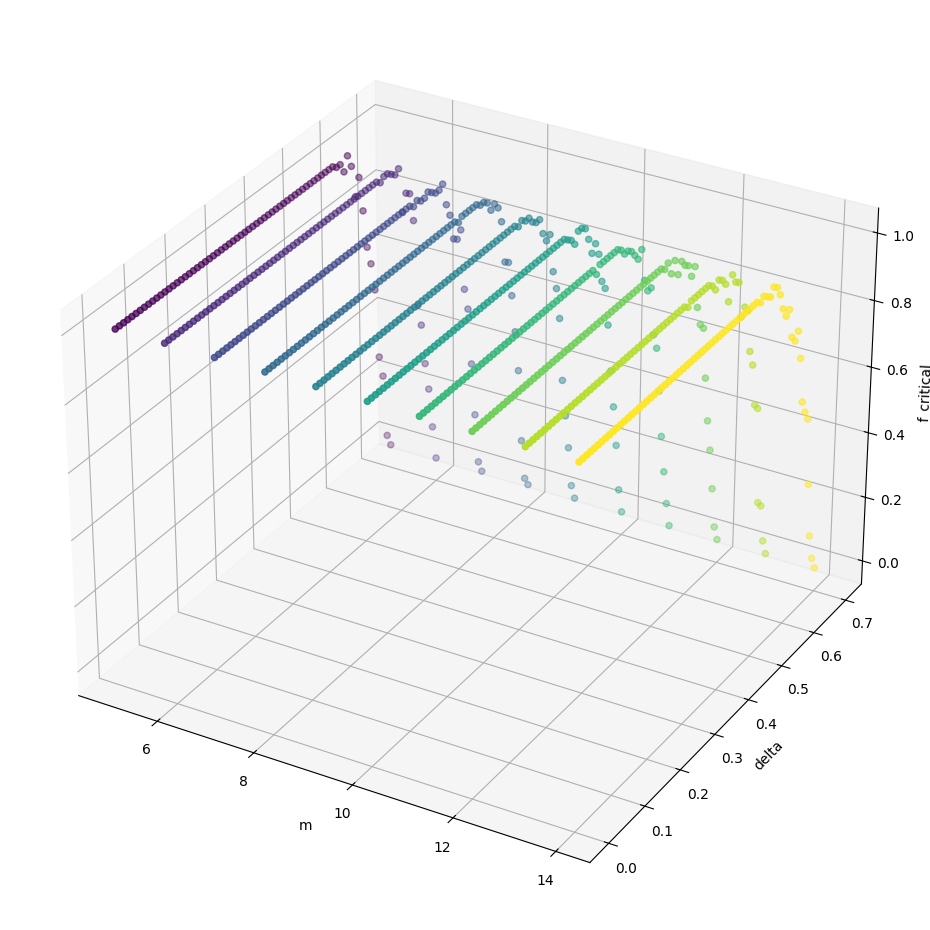

In [133]:
%matplotlib inline
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(xs=data_collector["m"], ys = data_collector["delta"], zs = data_collector["f_crit"], c=data_collector["m"],marker="o")
ax.set_xlabel("m")
ax.set_ylabel("delta")
ax.set_zlabel("f_critical")
ax.set_position([0.1,0.1,1.3,1.3])

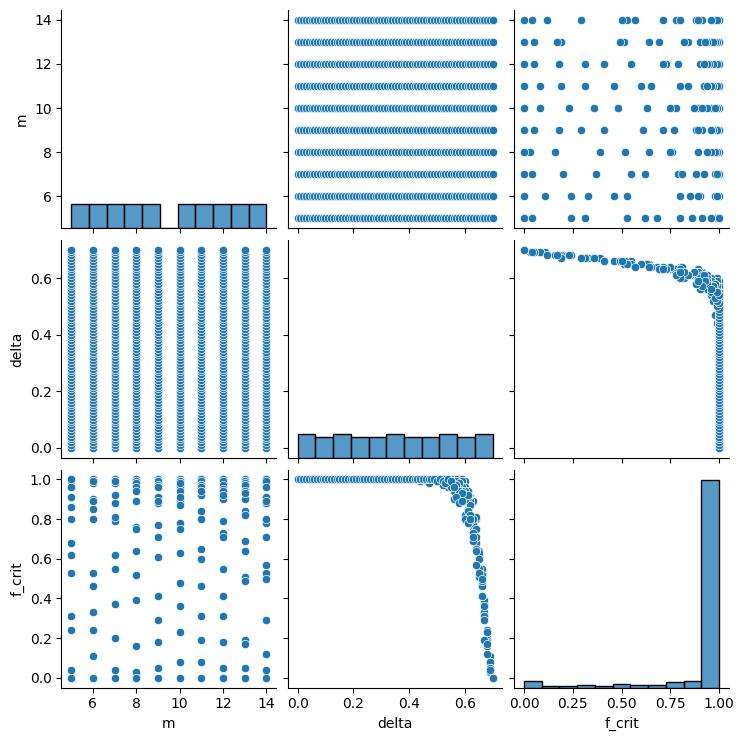

In [77]:
sns.pairplot(data_collector)

In [57]:
data_collector_real_states = pd.DataFrame(data={'m':[], 'delta':[], 'f_crit':[]})

In [62]:
for m in range(5,10):
    for delta in np.arange(0.0,0.70,0.05):
        data_collector_real_states = pd.concat([data_collector_real_states, pd.DataFrame(data={'m':[m], 'delta':[delta], 'f_crit':[f_critical(high_risk_condition_real_states(model=model_gen(delta=delta), m=m))]})])


In [55]:
high_risk_condition_real_states(model = model_gen(delta = 0.5), m = 6)

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [64]:
data_collector_real_states

,m,delta,f_crit
0,5.0,0.00,1.00
0,5.0,0.05,1.00
0,5.0,0.10,1.00
0,5.0,0.15,1.00
0,5.0,0.20,1.00
...,...,...,...
0,9.0,0.45,0.99
0,9.0,0.50,1.00
0,9.0,0.55,0.98
0,9.0,0.60,0.89


In [86]:
# training of neural network model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler


In [80]:

X, y = data_collector.iloc[:,[0,1]], data_collector.iloc[:,2]

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

In [87]:
# training of model
mlp_reg = MLPRegressor(hidden_layer_sizes=[10,10,3], max_iter= 1000, random_state=42)
pipeline = make_pipeline(MinMaxScaler(), mlp_reg)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test,y_pred)
print(f"Root mean squared error: {rmse}\nR squared: {r_squared}")

Root mean squared error: 0.009421647739841481
R squared: 0.8429500091941093
